In [2]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

import os
os.chdir('/home/spankaew/Git/astrologics')

import sys
sys.path.append('/home/spankaew/Git/astrologics/src')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

In this script, we explore what are the cause of low agreement between two clustering approach - attractor-based clustering approach and the simulation-based clustering approach. 

# Human Gonadal Sex Determination_26573569

## Load the model

In [3]:
model_name = 'Human Gonadal Sex Determination_26573569'

## Load the calculated attractor

We load the calculated attractor data and attractor group as defined earlier in the script 
`Kadelka_model_calculate_attractors.py`

In [4]:
attractor_path = '/home/spankaew/Git/astrologics/data/attractor_group/calculated_attractor/' + model_name + '_attractors.csv'
attractor_data = pd.read_csv(attractor_path, dtype=str)
attractor_data.rename(columns={'Unnamed: 0': 'attractors'}, inplace=True)
attractor_data.set_index('attractors', inplace=True)
attractor_data = attractor_data.astype(int)  # Convert the data to integers without affecting the index


We also load the pre-processed attractor group and create a dictionary object for later use.

In [5]:
attractor_group_path = '/home/spankaew/Git/astrologics/data/attractor_group/attractor_group/' + model_name + '_attractor_group.csv'
attractor_group = pd.read_csv(attractor_group_path, index_col = 0)
attractor_group_dict = attractor_group['attractor_group'].to_dict()

## Initiating the AstroLogics pipeline

In [6]:
model_path = '/home/spankaew/Git/astrologics/inferred_model/' + model_name  + '/'
model = le.LogicEnsemble(model_path, project_name = 'test')
model.create_simulation()

Simulation object created


As we have already simulated the model, we used the simulated data from previously.

In [7]:
simulation_path = '/home/spankaew/Git/astrologics/data/simulation_files/' + model_name + '_simulation.csv'
model.simulation.simulation_df = pd.read_csv(simulation_path, index_col = 0)

We then calculated the distance matrix from the simulation file

In [8]:
model.create_trajectory()
model.trajectory.calculate_distancematrix(mode = 'endpoint')

Trajectory object created
Calculating distance matrix for endpoint simulation...
Distance matrix calculated successfully.


### Calculate the MDS distance

In this part of the script, we visualized the calculated differences between the model using the MDS dimention reduction.

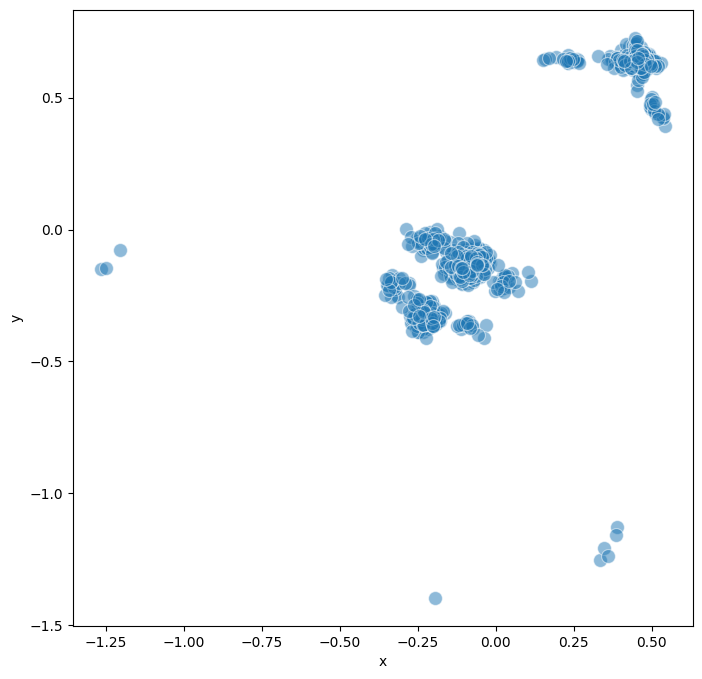

In [9]:
# Perform MDS (Multidimensional Scaling) for visualization
model.trajectory.calculate_MDS()
model.trajectory.plot_MDS(s = 100, fig_size = (8,8))

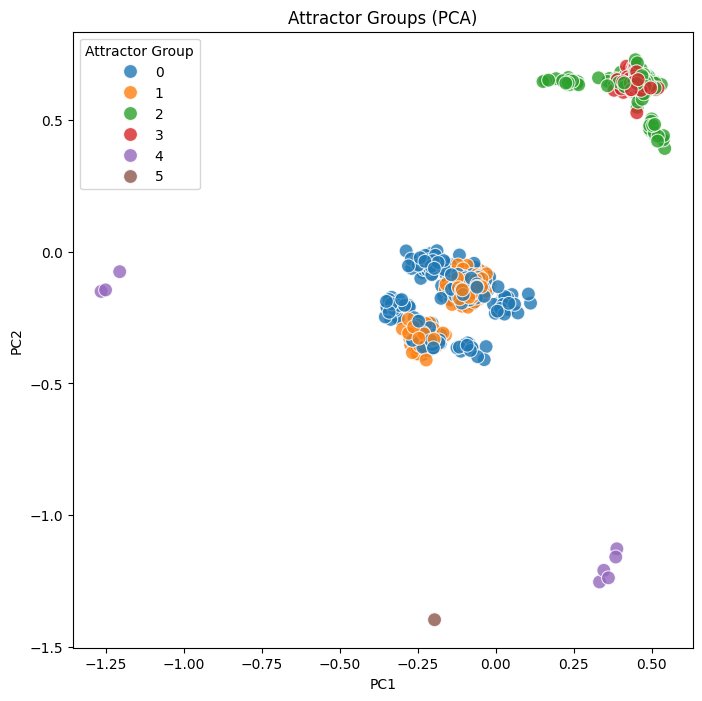

In [10]:
coords = model.trajectory.mds_coords
coords['attractor_group'] = coords.index.map(attractor_group_dict)

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x=coords['x'],
    y=coords['y'],
    hue=coords['attractor_group'],
    palette='tab10',
    s=100,
    alpha=0.8
)
plt.legend(title="Attractor Group")
plt.grid(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Attractor Groups (PCA)')
plt.show()

Calculated k-means clustering with 1 clusters.


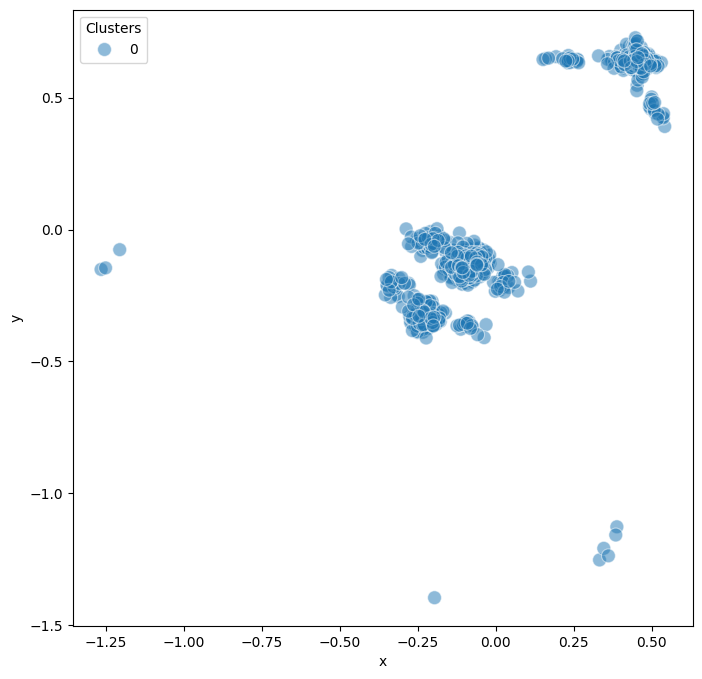

In [11]:
model.trajectory.calculate_kmean_cluster(n_cluster= 1, random_state = 12345)
model.trajectory.plot_MDS(plot_cluster=True, fig_size = (8,8), s =100)

# Comparison of model's attractor identification method.

In this part of the script, we visualize the heatmap showing how each model contains different attractor groups.

We then illustrated how these attractor states are reached in by the result of MaBoSS simulation, in the form of `state_activation_probability`

Finally, we illustrated how these `state_activation_probability` are translated to the `node_activation_probability`. These translation lower the granularity of the separated states into nodes activation. 

## Overview

This analysis compares three related concepts derived from the same Boolean model and simulations:

- Attractor groups: clusters of terminal behaviors of the model
  
- State activation probability: probability distribution over full network states at the final time point
  
- Node activation probability: marginal activation probabilities of nodes implied by the state distribution

The goal is to clarify how these objects relate, how to read the accompanying figures, and why clustering based on attractors can differ from clustering based on simulation outcomes.

## Key definitions

- **Attractor** - An attractor is a terminal behavior of the Boolean network, either a fixed point or a cycle. Each attractor corresponds to one or more states that the dynamics visit indefinitely.
    
- **Attractor group** - Attractors clustered by similarity into labeled groups. We use a precomputed mapping attractor → attractor_group and visualize how models distribute across these groups.
    
- **State activation probability (SAP)** - The probability of each full network state at the end of a simulation run, estimated by MaBoSS or equivalent stochastic simulation.
    
    Formally: P(s) for state s at the end time point.
    
- **Node activation probability (NAP)** - The marginal activation probability of each node at the end time point, obtained by summing state probabilities over the states where that node is ON.
    
    For node i: P(x_i = 1) = Σ_s P(s) · 1[s_i = 1]

In [12]:
from scipy.cluster.hierarchy import linkage, leaves_list

# Transpose your data so rows are models/attractors
data = attractor_data.transpose()

# Map attractor group values to colors
unique_groups = attractor_group['attractor_group'].unique()
color_palette = sns.color_palette('tab10', len(unique_groups))
color_map = dict(zip(unique_groups, color_palette))
row_colors = data.columns.map(attractor_group_dict).map(color_map)

# Compute linkage matrix (default method is 'average', you can use 'ward', 'single', etc.)
Z = linkage(data, method='average', metric='euclidean')

# Get the order of rows as in clustermap
ordered_indices = leaves_list(Z)
ordered_rows = data.index[ordered_indices]

# Define the plotting data
data = data.loc[ordered_rows, :]
row_colors = ordered_rows.map(attractor_group_dict).map(color_map)

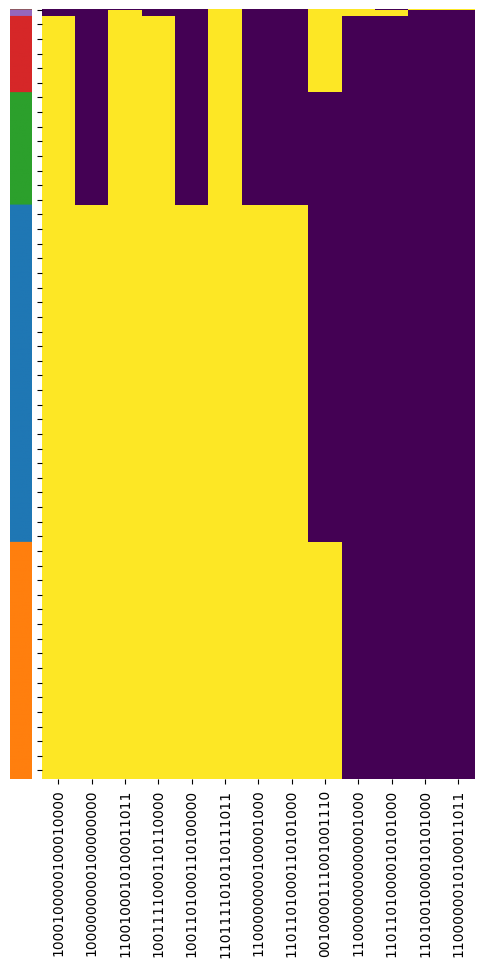

In [13]:
# Add row color bar
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize=(6, 10))
sns.heatmap(data, ax=ax, cmap='viridis', cbar=False)
ax.set_yticklabels([])
#ax.set_xticklabels([])
ax.set_xlabel(None)

# Convert colors to RGB array
row_colors_arr = np.array([mcolors.to_rgb(c) for c in row_colors])

# Create a new axes for the color bar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
color_ax = divider.append_axes("left", size="5%", pad=0.1)

# Fix: show each color as a row in the color bar
color_ax.imshow(row_colors_arr[:, np.newaxis], aspect='auto')
color_ax.axis('off')

plt.show()

To calculate the states activation probability, we implemented a function called `run_states_simulation` which take in the same inputs as `run_simulation`. This function gives the `state_activation_probability` as output, which more directly related to the attractor states. 

However, for model that contains multiple attractors states, this function may have a problem generating the `state_activation_probability` matrix.

In [14]:
# Define the initial condition
test = pd.read_csv(model.path + '/bn_0.bnet', sep = ',', header = None)
test[1] = 0.5
test_dict = dict(zip(test[0], test[1]))

# Run the simulation with states as the output
model.simulation.run_states_simulation(initial_state=test_dict)

# Get the states activation probability DataFrame
states_df = model.simulation.states_df
states_df.drop('timepoint', axis=1, inplace=True)
states_df.set_index('model_id', inplace=True)

Start simulation


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation completed : object states_df has been created


In [15]:
# Transpose your data so rows are models/attractors
data_states = model.simulation.states_df

# Define the plotting data
data_states = data_states.loc[ordered_rows, :]

In [16]:
endtimepoint_df = model.simulation.simulation_df.loc[model.simulation.simulation_df['timepoint'] == model.simulation.simulation_df['timepoint'].max()]
endtimepoint_df.drop(columns=['timepoint'], inplace=True)
endtimepoint_df.set_index('model_id', inplace=True)

# Transpose your data so rows are models/attractors
data_node = endtimepoint_df

# Define the plotting data
data_node = data_node.loc[ordered_rows, :]

/tmp/ipykernel_86991/1780199036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endtimepoint_df.drop(columns=['timepoint'], inplace=True)


In [ ]:
import re

def paths_to_binary(nodes, paths):
    # Make a stable index mapping for node positions
    idx = {n: i for i, n in enumerate(nodes)}
    
    out = []
    for p in paths:
        # split on '-', '—', '–' with optional spaces
        parts = [s.strip() for s in re.split(r'\s*[-–—]\s*', p)]
        bits = ['0'] * len(nodes)
        for node in parts:
            if node in idx:
                bits[idx[node]] = '1'
        out.append(''.join(bits))
    return out

# Convert states to binary states
node_name = test[0]
nodes = node_name
paths = data_states.columns
binary_path = paths_to_binary(nodes, paths)

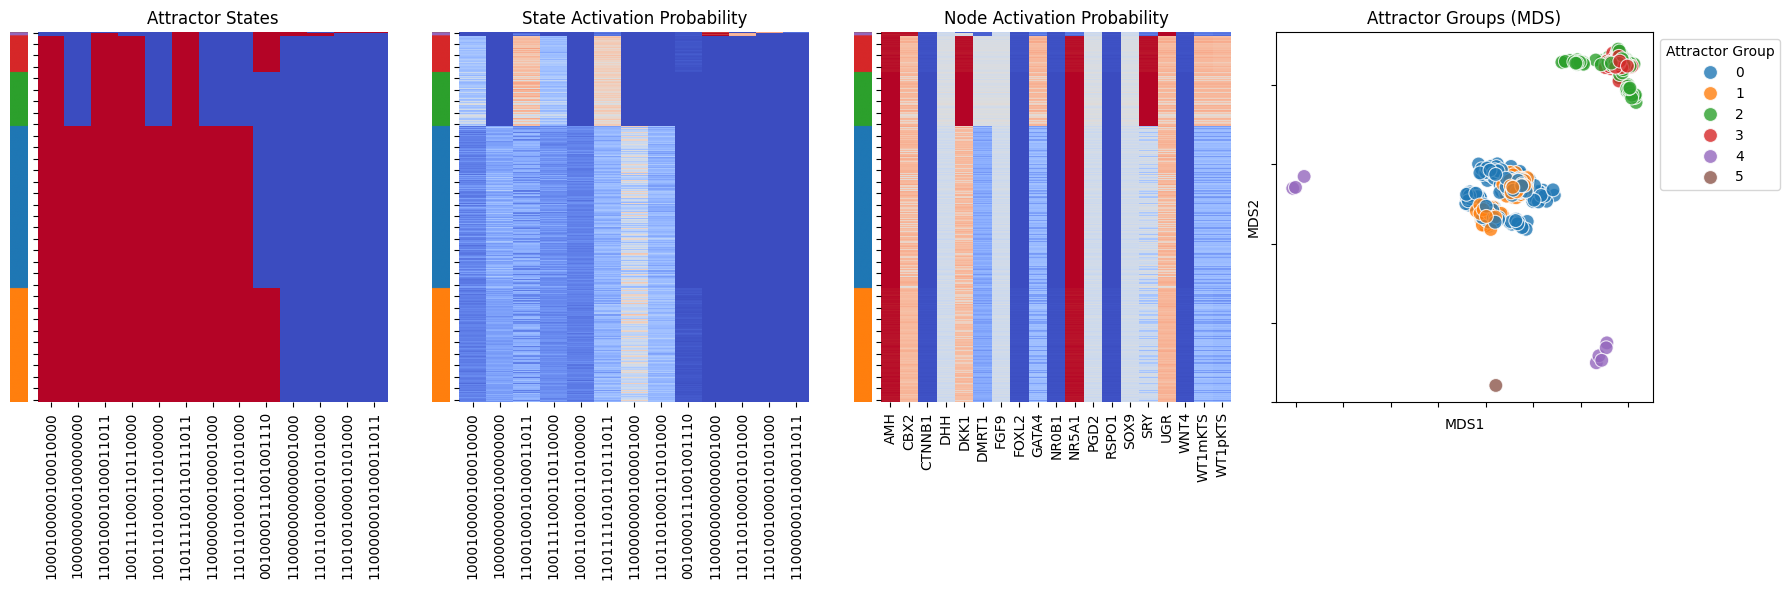

In [50]:
# Combine three heatmaps and the scatter plot into one figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Attractor heatmap
sns.heatmap(data, ax=axes[0], cmap='coolwarm', cbar=False)
axes[0].set_title('Attractor States')
axes[0].set_yticklabels([])
axes[0].set_xlabel(None)
row_colors_arr = np.array([mcolors.to_rgb(c) for c in row_colors])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider0 = make_axes_locatable(axes[0])
color_ax0 = divider0.append_axes("left", size="5%", pad=0.1)
color_ax0.imshow(row_colors_arr[:, np.newaxis], aspect='auto')
color_ax0.axis('off')

# State activation probability heatmap
data_states_plot = data_states.copy()
data_states_plot.columns = binary_path
data_states_plot = data_states_plot.loc[:,data.columns]
sns.heatmap(data_states_plot, ax=axes[1], cmap='coolwarm', cbar=False)
axes[1].set_title('State Activation Probability')
axes[1].set_yticklabels([])
axes[1].set_xlabel(None)
row_colors_arr_states = np.array([mcolors.to_rgb(c) for c in row_colors])
divider1 = make_axes_locatable(axes[1])
color_ax1 = divider1.append_axes("left", size="5%", pad=0.1)
color_ax1.imshow(row_colors_arr_states[:, np.newaxis], aspect='auto')
color_ax1.axis('off')

# Node activation probability heatmap
sns.heatmap(data_node[node_name], ax=axes[2], cmap='coolwarm', cbar=False)
axes[2].set_title('Node Activation Probability')
axes[2].set_yticklabels([])
axes[2].set_xlabel(None)
row_colors_arr_node = np.array([mcolors.to_rgb(c) for c in row_colors])
divider2 = make_axes_locatable(axes[2])
color_ax2 = divider2.append_axes("left", size="5%", pad=0.1)
color_ax2.imshow(row_colors_arr_node[:, np.newaxis], aspect='auto')
color_ax2.axis('off')

# Scatter plot (MDS)
coords = model.trajectory.mds_coords
coords['attractor_group'] = coords.index.map(attractor_group_dict)
sns.scatterplot(
    x=coords['x'],
    y=coords['y'],
    hue=coords['attractor_group'],
    palette='tab10',
    s=100,
    alpha=0.8,
    ax=axes[3]
)
axes[3].set_title('Attractor Groups (MDS)')
axes[3].set_xlabel('MDS1')
axes[3].set_ylabel('MDS2')
axes[3].grid(False)
axes[3].legend(title="Attractor Group", loc='best', bbox_to_anchor=(1, 1))
axes[3].set_xticklabels([])
axes[3].set_yticklabels([])

plt.tight_layout()
plt.show()


In [ ]:
import re

def paths_to_binary(nodes, paths):
    # Make a stable index mapping for node positions
    idx = {n: i for i, n in enumerate(nodes)}
    
    out = []
    for p in paths:
        # split on '-', '—', '–' with optional spaces
        parts = [s.strip() for s in re.split(r'\s*[-–—]\s*', p)]
        bits = ['0'] * len(nodes)
        for node in parts:
            if node in idx:
                bits[idx[node]] = '1'
        out.append(''.join(bits))
    return out

# Convert states to binary states
nodes = node_name
paths = data_states.columns
binary_path = paths_to_binary(nodes, paths)